In [98]:
#part c

In [3]:
import collections
import warnings

# The workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.optimize
import numdifftools as ndt

# Plotting modules
import matplotlib.pyplot as plt

# MCMC utilities
import emcee

# BE/Bi 103 utilities
import sys
sys.path.append('/Users/elenaperry/Desktop/GitHub/bebi103_utils')
import bebi103

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Pull out wild type and mutant and take NaNs to be zero
# Load data
df = pd.read_csv('./data/mean_rest_bouts.csv', comment='#')

df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)
df.head()

,fish,genotype,mean_rest_bout_length
2,FISH11,mut,2.255556
3,FISH12,mut,1.529412
4,FISH13,mut,2.373626
5,FISH14,wt,2.352941
7,FISH18,wt,2.111111


In [8]:
wt = df[df['genotype']=='wt']
wt = wt[('mean_rest_bout_length')]
mut = df[df['genotype']=='mut']
mut = mut[('mean_rest_bout_length')]

In [9]:
# Define log of the posterior
def log_post(p, x_1, x_2):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_1
    p[1] = mu_2
    p[2] = sigma_1
    p[3] = sigma_2
    """
    # Unpack parameters
    mu_1, mu_2, sigma_1, sigma_2 = p
    
    # Make sure we have everything in the right range
    if (sigma_1 < 0) or (sigma_2 < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_1 = st.norm.logpdf(x_1, mu_1, sigma_1).sum() - np.log(sigma_1)
    log_post_2 = st.norm.logpdf(x_2, mu_2, sigma_2).sum() - np.log(sigma_1)

    # Add them up to return
    return log_post_1 + log_post_2

In [10]:
# Arguments to pass to log posterior
args = (wt, mut)

# Parameters and how we start them
params = collections.OrderedDict([('mu_1', (np.random.uniform, (0, 1))),
                                  ('mu_2', (np.random.uniform, (0, 1))),
                                  ('sigma_1', (np.random.exponential, (0.1,))),
                                  ('sigma_2', (np.random.exponential, (0.1,)))])

# Define walker settings
n_walkers = 50
n_burn = 1000
n_steps = 10000

# Run MCMC
df_mcmc = bebi103.run_ensemble_emcee(log_post, n_burn, n_steps, 
                                     n_walkers=n_walkers, p_dict=params, 
                                     args=args)

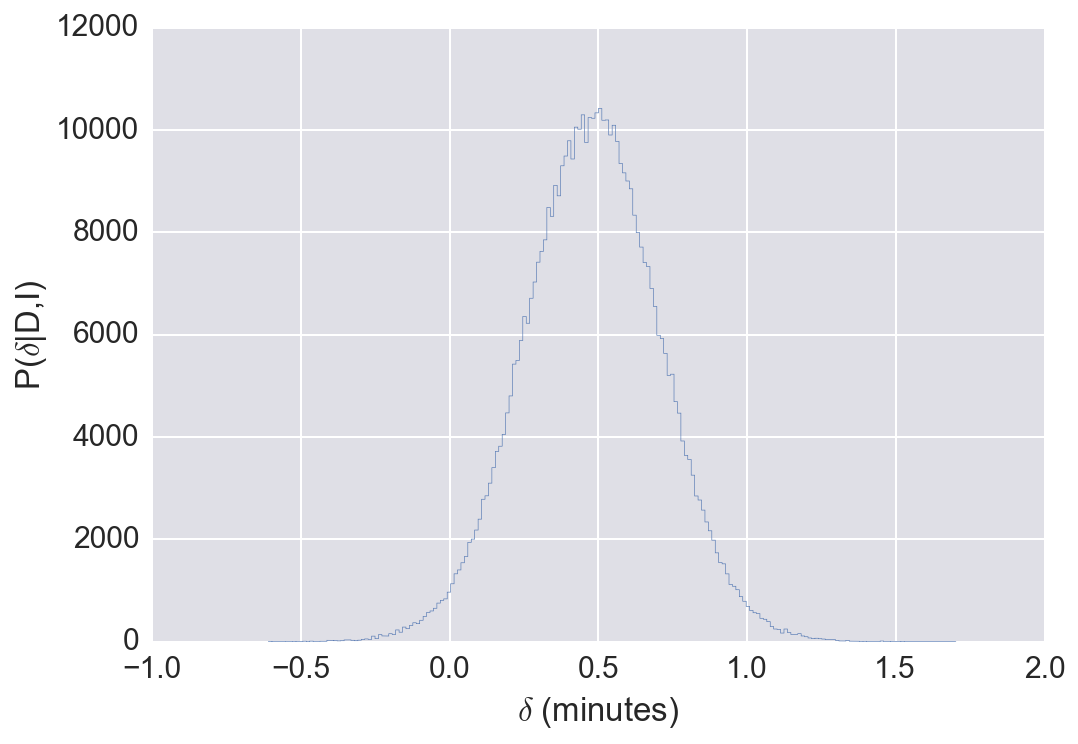

In [11]:
df_mcmc['mu_diff'] = df_mcmc['mu_1'] - df_mcmc['mu_2']
_ = plt.hist(df_mcmc['mu_diff'], bins=200, histtype='step')
plt.xlabel('$\delta$ (minutes)')
plt.ylabel('P($\delta$|D,I)')

In [12]:
max_ind = np.argmax(df_mcmc['lnprob'])
mu_diff_map = df_mcmc.loc[max_ind,'mu_diff'] 
mu_diff_error = df_mcmc['mu_diff'].std()
print("""δ = {0:.3f} ± {1:.3f} minutes""".format(mu_diff_map, 1.96*mu_diff_error))
print("""95% credible region: {0:.3f} ≤ δ ≤ {1:.3f} minutes""".format((mu_diff_map - 1.96*mu_diff_error), 
                                                                 (mu_diff_map + 1.96*mu_diff_error)))

δ = 0.487 ± 0.446 minutes
95% credible region: 0.042 ≤ δ ≤ 0.933 minutes


In [13]:
#this code has been modified from previous HW solutions.

# Define log of the posterior
def log_post(p, x_wt, x_mut):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_wt
    p[1] = mu_mut
    p[2] = sigma_wt
    p[3] = sigma_mut
    """
    # Unpack parameters
    mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
    # Make sure we have everything in the right range
    if (sigma_wt < 0) or (sigma_mut < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_wt = st.norm.logpdf(x_wt, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    
    log_post_mut = st.norm.logpdf(x_mut, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

    # Add them up to return
    return log_post_wt + log_post_mut

def negative_log_post(p, x_wt,x_mut):
    return -log_post(p,x_wt,x_mut)

#MAP
args = (wt,mut)

p0 = np.array([ 2, 1.5, 0.5, 0.8])

hes_fun = ndt.Hessian(log_post)
res = scipy.optimize.minimize(negative_log_post, p0, args=args)
hes = hes_fun(res.x,wt,mut)
cov = -np.linalg.inv(hes)

bayesian_estimate_diff = res.x[0]-res.x[1]
credible_interval = 1.96 * np.sqrt(np.sqrt(cov[0,0])**2 + np.sqrt(cov[1,1])**2)

print("The bayesian estimate of the difference of the mean is", 
      bayesian_estimate_diff, "±", credible_interval)

The bayesian estimate of the difference of the mean is 0.482335461654 ± 0.397809847833


# Part E

In [138]:
# Define log of the posterior for H_0 
def log_post_H0(p, x):
    """
    Returns the log of the posterior for a Gaussian.
    p[0] = mu
    p[1] = sigma
    """
    # Unpack parameters
    mu, sigma = p
    
    # Make sure we have everything in the right range
    if (sigma < 0):
        return -np.inf

    # Add them up to return
    return st.norm.logpdf(x, mu, sigma).sum() - np.log(sigma)

In [145]:
#this code has been modified from previous HW solutions.

# Define log of the posterior
def log_post(p, x_wt, x_mut):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_wt
    p[1] = mu_mut
    p[2] = sigma_wt
    p[3] = sigma_mut
    """
    # Unpack parameters
    mu_wt, mu_mut, sigma_wt, sigma_mut = p
    
    # Make sure we have everything in the right range
    if (sigma_wt < 0) or (sigma_mut < 0):
        return -np.inf

    # Compute separate parts of posterior from each sample
    log_post_wt = st.norm.logpdf(x_wt, mu_wt, sigma_wt).sum() - np.log(sigma_wt)
    
    log_post_mut = st.norm.logpdf(x_mut, mu_mut, sigma_mut).sum() - np.log(sigma_mut)

    # Add them up to return
    return log_post_wt + log_post_mut

def negative_log_post(p, x_wt,x_mut):
    return -log_post(p,x_wt,x_mut)

#MAP
args = (wt,mut)

p0 = np.array([ 2, 1.5, 0.5, 0.8])

hes_fun = ndt.Hessian(log_post)
res = scipy.optimize.minimize(negative_log_post, p0, args=args)
hes = hes_fun(res.x,wt,mut)
cov = -np.linalg.inv(hes)

bayesian_estimate_diff = res.x[0]-res.x[1]
credible_interval = 1.96 * np.sqrt(np.sqrt(cov[0,0])**2 + np.sqrt(cov[1,1])**2)

print("The bayesian estimate of the difference of the mean is", 
      bayesian_estimate_diff, "±", credible_interval)

The bayesian estimate of the difference of the mean is 0.482335452396 ± 0.397809846791


In [140]:
# Instantiate Hessian for log posterior for H_0
hes_fun = ndt.Hessian(log_post_H0)

# Compute Hessian at MAP for H_0
hes = hes_fun(np.asarray([df['mean_rest_bout_length'].mean(), 
                          df['mean_rest_bout_length'].std()]), df['mean_rest_bout_length'])

# Calculate covariance matrix for H_0
cov0 = -np.linalg.inv(hes)

In [144]:
# Calculate the log of the good fit ratio
log_good_fit_ratio = \
st.norm.logpdf(df['mean_rest_bout_length'], df['mean_rest_bout_length'].mean(), df['mean_rest_bout_length'].std()).sum() \
- st.norm.logpdf(wt, res.x[0], res.x[2]).sum() \
- st.norm.logpdf(mut, res.x[1], res.x[3]).sum()

# Caclulate the log of the Occam factor
log_occam = np.log(res.x[2]) + np.log(res.x[3]) + np.log(2 * np.pi) + np.log(np.linalg.det(cov0))/2 \
- np.log(df['mean_rest_bout_length'].std()) - 2 * np.log(2 * np.pi) - np.log(np.linalg.det(cov1))/2

# Calculate and print the odds ratio
print("""Odds ratio = {0:.4f}""".format(np.exp(log_good_fit_ratio + log_occam)))

Odds ratio = 0.0830


# F

In [163]:
def odds_ratio(data, cov, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map):
    """
    This function calculates the odds ratio for H_0 and H_1.
    
    data = the dataframe with all of the wt and mut fish
    cov = the covariance matrix calculated for the joint Gaussian distribution in part (c)
    wt_mu_map = the MAP for the wild-type mu as calculated in part (c)
    wt_sigma_map = the MAP for the wild-type sigma as calculated in part (c)
    mut_mu_map = the MAP for the mutant mu as calculated in part (c)
    mut_sigma_map = the MAP for the mutant sigma as calculated in part (c)
    
    """
    # Set up additional variables to pass in as arguments to the sub-functions
    wt_fish = data[data['genotype']=='wt']
    mut_fish = data[data['genotype']=='mut']
    
    p = np.asarray([data['mean_rest_bout_length'].mean(), data['mean_rest_bout_length'].std()])
    x = data['mean_rest_bout_length']
    wt_mut = np.asarray([wt_fish['mean_rest_bout_length'], mut_fish['mean_rest_bout_length']])
    
    # Define log of the posterior for H_0 
    def log_post_H0(p, x):
        """
        Returns the log of the posterior for a Gaussian.
        p[0] = mu
        p[1] = sigma
        """
        # Unpack parameters
        mu, sigma = p
    
        # Make sure we have everything in the right range
        if (sigma < 0):
            return -np.inf

        # Add them up to return
        return st.norm.logpdf(x, mu, sigma).sum() - np.log(sigma)

    def cov_H0(p, x):    
        """
        Calculates the covariance matrix for H_0
        """
        # Instantiate Hessian for log posterior for H_0
        hes_fun = ndt.Hessian(log_post_H0)

        # Compute Hessian at MAP for H_0
        hes = hes_fun(p, x)

        return -np.linalg.inv(hes)

    def log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map): 
        """
        Calculates the log of the goodness of fit ratio
        """
        # Unpack parameters
        mu, sigma = p
        
        return st.norm.logpdf(x, mu, sigma).sum() \
    - st.norm.logpdf(wt_mut[0], wt_mu_map, wt_sigma_map).sum() \
    - st.norm.logpdf(wt_mut[1], mut_mu_map, mut_sigma_map).sum()

    def log_occam(p, x, wt_sigma_map, mut_sigma_map, cov):
        """
        Calculates the log of the Occam factor
        """
        # Unpack parameters
        mu, sigma = p
        
        return np.log(wt_sigma_map) + np.log(mut_sigma_map) + np.log(2 * np.pi) + np.log(np.linalg.det(cov_H0(p, x)))/2 \
    - np.log(sigma) - 2 * np.log(2 * np.pi) - np.log(np.linalg.det(cov))/2
      
    return np.exp(log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map) \
                  + log_occam(p, x, wt_sigma_map, mut_sigma_map, cov))



In [164]:
odds_ratio(df, cov, res.x[0], res.x[2], res.x[1], res.x[3])

0.083039542183335036

In [14]:

def log_post_H0(p, x):
    """
    Returns the log of the posterior for a Gaussian.
    p[0] = mu
    p[1] = sigma
    """
    # Unpack parameters
    mu, sigma = p

    # Make sure we have everything in the right range
    if (sigma < 0):
        return -np.inf

    # Add them up to return
    return st.norm.logpdf(x, mu, sigma).sum() - np.log(sigma)

def cov_H0(p, x):    
    """
    Calculates the covariance matrix for H_0
    """
    # Instantiate Hessian for log posterior for H_0
    hes_fun = ndt.Hessian(log_post_H0)

    # Compute Hessian at MAP for H_0
    hes = hes_fun(p, x)

    return -np.linalg.inv(hes)

def log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map): 
    """
    Calculates the log of the goodness of fit ratio
    """
    # Unpack parameters
    mu, sigma = p

    return st.norm.logpdf(x, mu, sigma).sum() \
- st.norm.logpdf(wt_mut[0], wt_mu_map, wt_sigma_map).sum() \
- st.norm.logpdf(wt_mut[1], mut_mu_map, mut_sigma_map).sum()

def log_occam(p, x, wt_sigma_map, mut_sigma_map, cov):
    """
    Calculates the log of the Occam factor
    """
    # Unpack parameters
    mu, sigma = p

    return np.log(wt_sigma_map) + np.log(mut_sigma_map) + np.log(2 * np.pi) + np.log(np.linalg.det(cov_H0(p, x)))/2 \
- np.log(sigma) - 2 * np.log(2 * np.pi) - np.log(np.linalg.det(cov))/2

In [15]:
def odds_ratio(data, cov, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map):
    """
    This function calculates the odds ratio for H_0 and H_1.
    
    data = the dataframe with all of the wt and mut fish
    cov = the covariance matrix calculated for the joint Gaussian distribution in part (c)
    wt_mu_map = the MAP for the wild-type mu as calculated in part (c)
    wt_sigma_map = the MAP for the wild-type sigma as calculated in part (c)
    mut_mu_map = the MAP for the mutant mu as calculated in part (c)
    mut_sigma_map = the MAP for the mutant sigma as calculated in part (c)
    
    """
    # Set up additional variables to pass in as arguments to the sub-functions
    wt_fish = data[data['genotype']=='wt']
    mut_fish = data[data['genotype']=='mut']
    
    p = np.asarray([data['mean_rest_bout_length'].mean(), data['mean_rest_bout_length'].std()])
    x = data['mean_rest_bout_length']
    wt_mut = np.asarray([wt_fish['mean_rest_bout_length'], mut_fish['mean_rest_bout_length']])
    
    return np.exp(log_good_fit_ratio(p, x, wt_mut, wt_mu_map, wt_sigma_map, mut_mu_map, mut_sigma_map) \
                + log_occam(p, x, wt_sigma_map, mut_sigma_map, cov))

In [16]:
odds_ratio(df, cov, res.x[0], res.x[2], res.x[1], res.x[3])

0.083039540560062838